# Capstone (1/3) - Netflix Recommender

## Navigation: 

* File (1/3) - EDA of data files and charts of the data

* File (2/3) - Recommender System using Surprise Library and Recommendations 

* File (3/3) - Recommender System using Tensorflow and Verdict

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split 

## 2. Dataset 1 - Financial & Subscriber Details

Data extracted directly from Financial Statements \
(URL: https://ir.netflix.net/investor-news-and-events/investor-events/default.aspx)

File consists of the following information:  
* Area: \
    UCAN = United States and Canada; \
    EMEA = Europe, Middle East and Africa; \
    LATAM = Latin America; & \
    APAC = Asia Pacific
* Quarter (Qtr): \
    1 = Jan-Mar \
    2 = Apr-Jun \
    3 = Jul-Sep \
    4 = Oct-Dec
* Year -- 2017 to 2021 (Mar)
* Revenue -- in US$'mil
* Subscribers -- in millions

In [2]:
# load Revenue & Subscriber File
fin_data =  pd.read_csv('NetflixConsolData_V3.csv')

In [3]:
# check the data
fin_data.head()

,Area,Qtr,Year,Revenue,Subscribers
0,United States and Canada,1,2017,1586,55
1,"Europe, Middle East and Africa",1,2017,482,20
2,Latin America,1,2017,331,15
3,Asia-Pacific,1,2017,116,5
4,United States and Canada,2,2017,1624,56


In [4]:
# Print the column names
fin_data.columns

Index(['Area', 'Qtr', 'Year', ' Revenue ', ' Subscribers '], dtype='object')

In [5]:
# Rename the column names & removing excessive spaces
fin_data.rename(columns={'Area': 'Region', ' Revenue ': 'Revenue', ' Subscribers ':'Subscribers'}, inplace=True)

In [6]:
# Replace the Area into Region (per Netflix Financial Statements) 
fin_data.replace({'United States and Canada':'UCAN', 'Europe,  Middle East and Africa': 'EMEA',
       'Latin America': 'LATAM', 'Asia-Pacific': 'APAC'}, inplace=True)

In [7]:
# Information overview 
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Region       68 non-null     object
 1   Qtr          68 non-null     int64 
 2   Year         68 non-null     int64 
 3   Revenue      68 non-null     int64 
 4   Subscribers  68 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 2.8+ KB


In [8]:
# Information statistical overview
fin_data.describe(include='all')

,Region,Qtr,Year,Revenue,Subscribers
count,68,68.000000,68.000000,68.000000,68.000000
unique,4,NaN,NaN,NaN,NaN
top,LATAM,NaN,NaN,NaN,NaN
freq,17,NaN,NaN,NaN,NaN
mean,NaN,2.411765,2018.647059,1152.911765,37.235294
std,NaN,1.149111,1.243067,863.283107,21.850317
min,NaN,1.000000,2017.000000,116.000000,5.000000
25%,NaN,1.000000,2018.000000,492.250000,20.000000
50%,NaN,2.000000,2019.000000,787.000000,31.000000
75%,NaN,3.000000,2020.000000,1805.250000,59.500000


In [9]:
# Consolidate all the revenue into a table. 
rev_data = pd.pivot_table(fin_data, columns='Year', index=['Region'], aggfunc='sum', values='Revenue')

# Convert the above pivot table to dataframe 
flat_rev = pd.DataFrame(rev_data.to_records())
flat_rev

,Region,2017,2018,2019,2020,2021
0,APAC,576,946,1469,2373,762
1,EMEA,2363,3964,5543,7772,2344
2,LATAM,1642,2237,2794,3156,837
3,UCAN,6660,8282,10051,11456,3171


In [10]:
# Consolidate all the revenue into a table. 
consol_data = pd.pivot_table(fin_data, columns='Year', index=['Region'], aggfunc='max', values='Subscribers')

# Convert the above pivot table to dataframe and sum by year
consol_data = pd.DataFrame(consol_data.to_records()).agg({'2017':['sum'], '2018':['sum'], '2019':['sum'], '2020':['sum']})
consol_data

,2017,2018,2019,2020
sum,111,140,167,204


<AxesSubplot:xlabel='Year'>

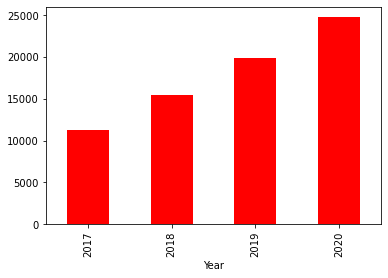

In [11]:
# Groupby subscribers to respective years and plot them, excluding 2021 because 2021 is incomplete.
consol_data = fin_data[fin_data.Year != 2021 ].groupby('Year')['Revenue'].sum()
consol_data.plot(kind='bar', color='r')

## 3. Dataset 2 - Netflix Prize Data (Original)

### (a) Load all files

#### (I) Combined 4 Text Data Files

In [12]:
# DataFrame to store all imported data

data = open('data.csv', mode='w')

files = ['combined_data_1.txt',
         'combined_data_2.txt',
         'combined_data_3.txt',
         'combined_data_4.txt']

# Remove the line with movie_id: and add a new column of movie_id
# Combine all data files into a csv file
for file in files:
  print("Opening file: {}".format(file))
  with open(file) as f:
    for line in f:
        line = line.strip()
        if line.endswith(':'):
            movie_id = line.replace(':', '')
        else:
            data.write(movie_id + ',' + line)
            data.write('\n')
data.close()

# Read all data into a pd dataframe
text_data = pd.read_csv('data.csv', names=['movie_id', 'user_id','rating','date'])

# See combined file of df
text_data

Opening file: combined_data_1.txt
Opening file: combined_data_2.txt
Opening file: combined_data_3.txt
Opening file: combined_data_4.txt


,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
100480502,17770,1790158,4,2005-11-01
100480503,17770,1608708,3,2005-07-19
100480504,17770,234275,1,2004-08-07
100480505,17770,255278,4,2004-05-28


In [13]:
# Using info to check the shape, column names and type of df
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   movie_id  int64 
 1   user_id   int64 
 2   rating    int64 
 3   date      object
dtypes: int64(3), object(1)
memory usage: 3.0+ GB


In [14]:
# convert date to datetime format
text_data['date'] = pd.to_datetime(text_data['date'], format='%Y-%m-%d')

In [15]:
# count the number of customers for this dataset 
text_data.user_id.nunique()

480189

In [16]:
# Check for any null values
text_data.isnull().sum()

movie_id    0
user_id     0
rating      0
date        0
dtype: int64

In [17]:
# Rating started from this date onwards: 
text_data['date'].min()

Timestamp('1999-11-11 00:00:00')

In [18]:
# Ratings collected ceased on this date:  
text_data['date'].max()

Timestamp('2005-12-31 00:00:00')

#### (II) Movie Details Dataset

Movie Dataset contains the following: 
* movie_id -- (1 to 17,770)
* release_year -- (1896 to 2005) The Year Movie was Released 
* movie_title -- in English

In [19]:
# reading movie details
movie_df =  pd.read_csv('movie_titles.csv', names=['movie_id','release_year','movie_title'], 
                        encoding = 'ISO-8859-1')

# See the movie data details
movie_df

,movie_id,release_year,movie_title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [20]:
# Check for any null values
movie_df.isnull().sum()

movie_id        0
release_year    7
movie_title     0
dtype: int64

In [21]:
# to get the exact row number for the null values 
movie_df[pd.isnull(movie_df).any(axis=1)]

,movie_id,release_year,movie_title
4387,4388,NaN,Ancient Civilizations: Rome and Pompeii
4793,4794,NaN,Ancient Civilizations: Land of the Pharaohs
7240,7241,NaN,Ancient Civilizations: Athens and Greece
10781,10782,NaN,Roti Kapada Aur Makaan
15917,15918,NaN,Hote Hote Pyaar Ho Gaya
16677,16678,NaN,Jimmy Hollywood
17666,17667,NaN,Eros Dance Dhamaka


In [22]:
# replace the release year accordingly 
movie_df.at[4387,'release_year'] = 2001
movie_df.at[4793,'release_year'] = 2001
movie_df.at[7240,'release_year'] = 2001
movie_df.at[10781,'release_year'] = 1974
movie_df.at[15917,'release_year'] = 1999
movie_df.at[16677,'release_year'] = 1994
movie_df.at[17666,'release_year'] = 1999

In [23]:
# Another check for any null values
movie_df.isnull().sum()

movie_id        0
release_year    0
movie_title     0
dtype: int64

In [24]:
# Convert the year to integer
movie_df['release_year'] = movie_df['release_year'].astype(int)

In [25]:
# Final check on the head for movie_df
movie_df.head()

,movie_id,release_year,movie_title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


#### (III) Merged Data - Combine (a) & (b) 

In [26]:
# Using Outer Join to merge both files using the Movie ID columns that's present in both files
df = pd.merge(text_data, movie_df, on='movie_id', how='outer')
df

,movie_id,user_id,rating,date,release_year,movie_title
0,1,1488844,3,2005-09-06,2003,Dinosaur Planet
1,1,822109,5,2005-05-13,2003,Dinosaur Planet
2,1,885013,4,2005-10-19,2003,Dinosaur Planet
3,1,30878,4,2005-12-26,2003,Dinosaur Planet
4,1,823519,3,2004-05-03,2003,Dinosaur Planet
...,...,...,...,...,...,...
100480502,17770,1790158,4,2005-11-01,2003,Alien Hunter
100480503,17770,1608708,3,2005-07-19,2003,Alien Hunter
100480504,17770,234275,1,2004-08-07,2003,Alien Hunter
100480505,17770,255278,4,2004-05-28,2003,Alien Hunter


### (b) General Visualisations

To understand more of the data we have retrieved from the above approx. 100million rows data.

#### (I) Rating Distribution 

In [27]:
# count the total number of ratings 
df.groupby("rating")["rating"].sum()

rating
1      4617990
2     20264160
3     86433741
4    135003832
5    115841160
Name: rating, dtype: int64

Text(0.5, 1.0, 'Rating Distribution from 1999 to 2005')

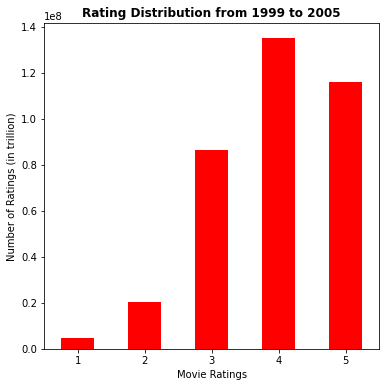

In [28]:
# set figure size 
plt.figure(figsize=(6,6))

# plot the ratings in a chart
df.groupby("rating")["rating"].sum().plot(kind='bar', color='r')

# set the respective labels 
plt.xticks(rotation=0)
plt.xlabel('Movie Ratings')
plt.ylabel('Number of Ratings (in trillion)')
plt.title('Rating Distribution from 1999 to 2005', fontweight="bold")

Text(0.5, 1.0, 'Rating Distribution from 1999 to 2005')

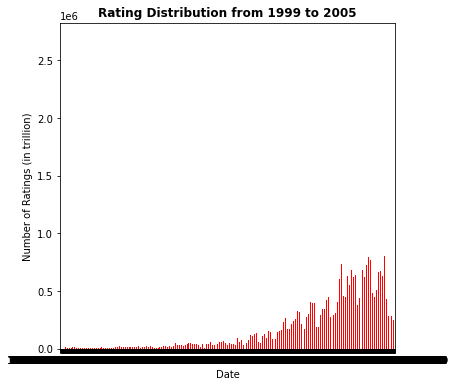

In [29]:
# set figure size 
plt.figure(figsize=(6,6))

# plot the ratings in a chart
df.groupby("date")["rating"].sum().plot(kind='bar', color='r')

# set the respective labels 
plt.xticks(rotation=0)
plt.xlabel('Date')
plt.ylabel('Number of Ratings (in trillion)')
plt.title('Rating Distribution from 1999 to 2005', fontweight="bold")

#### (II) Top 10 Movie Titles by Ratings

<Figure size 1080x720 with 0 Axes>

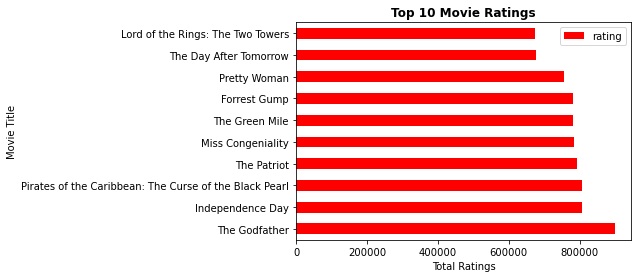

In [30]:
# sum of all ratings by movie title
mt_rank = df.groupby("movie_title")["rating"].sum()

# sort them by highest rating first
mt_rank = mt_rank.sort_values(ascending=False)

# convert to dataframe
top_10mt = pd.DataFrame(mt_rank.head(10))

# set figure size 
plt.figure(figsize=(15,10))

# plot graph
top_10mt.plot(kind='barh', color='r')

# set the respective labels 
plt.xlabel('Total Ratings')
plt.ylabel('Movie Title')
plt.title('Top 10 Movie Ratings', fontweight='bold')
plt.show()

### (c) Split the Files for Analysis - Choosing the size of data

Due to time constraints and laptop compatibility for 1 pax, I decided to go ahead with 5 million rows. 
\
Below are the steps I took to cut down on the data size in order for my device to run the codes in File 2 of 3 using Surprise Library. 

#### (I) Decision 1: To use the dataset where users rated during Jan to Dec 2005

Limitations: Due to the large dataset, we will be using the data where ratings were provided from 2005 onwards. 

In [31]:
# setting the conditions and check before exporting data out. 
d1 = df[df.date > '2004-12-31']
d1

,movie_id,user_id,rating,date,release_year,movie_title
0,1,1488844,3,2005-09-06,2003,Dinosaur Planet
1,1,822109,5,2005-05-13,2003,Dinosaur Planet
2,1,885013,4,2005-10-19,2003,Dinosaur Planet
3,1,30878,4,2005-12-26,2003,Dinosaur Planet
5,1,893988,3,2005-11-17,2003,Dinosaur Planet
...,...,...,...,...,...,...
100480497,17770,834323,2,2005-10-04,2003,Alien Hunter
100480501,17770,311124,3,2005-09-29,2003,Alien Hunter
100480502,17770,1790158,4,2005-11-01,2003,Alien Hunter
100480503,17770,1608708,3,2005-07-19,2003,Alien Hunter


Text(0.5, 1.0, 'Rating Distribution in 2005')

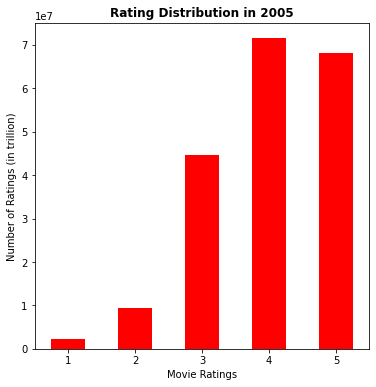

In [32]:
# set figure size 
plt.figure(figsize=(6,6))

# plot the ratings in a chart
d1.groupby("rating")["rating"].sum().plot(kind='bar', color='r')

# set the respective labels 
plt.xticks(rotation=0)
plt.xlabel('Movie Ratings')
plt.ylabel('Number of Ratings (in trillion)')
plt.title('Rating Distribution in 2005', fontweight="bold")

The rating distribution was almost similar as the original dataset. To consider using the full year data if computer's processor allows. 

Text(0.5, 1.0, 'Rating Distribution in 2005')

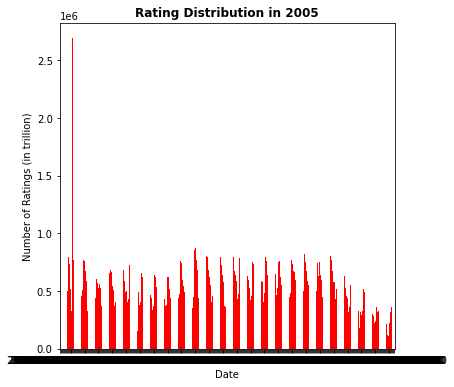

In [33]:
# set figure size 
plt.figure(figsize=(6,6))

# plot the ratings in a chart
d1.groupby("date")["rating"].sum().plot(kind='bar', color='r')

# set the respective labels 
plt.xticks(rotation=0)
plt.xlabel('Date')
plt.ylabel('Number of Ratings (in trillion)')
plt.title('Rating Distribution in 2005', fontweight="bold")

<Figure size 1080x720 with 0 Axes>

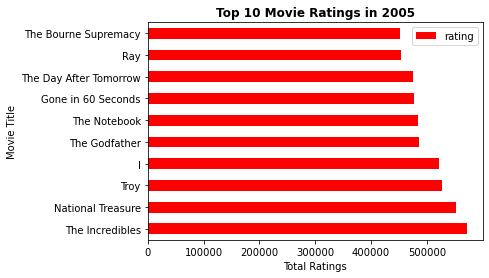

In [34]:
# sum of all ratings by movie title
mt_rank1 = d1.groupby("movie_title")["rating"].sum()

# sort them by highest rating first
mt_rank1 = mt_rank1.sort_values(ascending=False)

# convert to dataframe
top_10mt1 = pd.DataFrame(mt_rank1.head(10))
top_10mt1

# set figure size 
plt.figure(figsize=(15,10))

# plot graph
top_10mt1.plot(kind='barh', color='r')

# set the respective labels 
plt.xlabel('Total Ratings')
plt.ylabel('Movie Title')
plt.title('Top 10 Movie Ratings in 2005', fontweight='bold')
plt.show()

In [35]:
# export 2005 data to csv file
d1.to_csv('2005-d1.csv', index=False)  

#### (II) Decision 2: To use the dataset where users rated during Jun to Dec 2005

In [36]:
# setting the conditions and check before exporting data out from June to December 2005 
d2 = df[df.date > '2005-05-31']
d2

,movie_id,user_id,rating,date,release_year,movie_title
0,1,1488844,3,2005-09-06,2003,Dinosaur Planet
2,1,885013,4,2005-10-19,2003,Dinosaur Planet
3,1,30878,4,2005-12-26,2003,Dinosaur Planet
5,1,893988,3,2005-11-17,2003,Dinosaur Planet
11,1,2207774,5,2005-06-06,2003,Dinosaur Planet
...,...,...,...,...,...,...
100480496,17770,2641559,3,2005-06-27,2003,Alien Hunter
100480497,17770,834323,2,2005-10-04,2003,Alien Hunter
100480501,17770,311124,3,2005-09-29,2003,Alien Hunter
100480502,17770,1790158,4,2005-11-01,2003,Alien Hunter


Text(0.5, 1.0, 'Rating Distribution from Jun to Dec 2005')

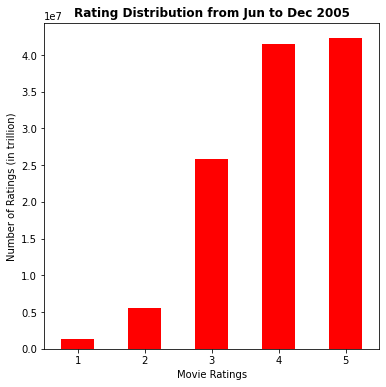

In [37]:
# set figure size 
plt.figure(figsize=(6,6))

# plot the ratings in a chart
d2.groupby("rating")["rating"].sum().plot(kind='bar', color='r')

# set the respective labels 
plt.xticks(rotation=0)
plt.xlabel('Movie Ratings')
plt.ylabel('Number of Ratings (in trillion)')
plt.title('Rating Distribution from Jun to Dec 2005', fontweight="bold")

Due to some limitations, the dataset criteria was change to ratings received from 1st June 2005 onwards. This gives us about 35million data and from the above graph, it seems to remove most #4 ratings as the graph has changed slightly. 


Text(0.5, 1.0, 'Rating Distribution from Jun to Dec 2005')

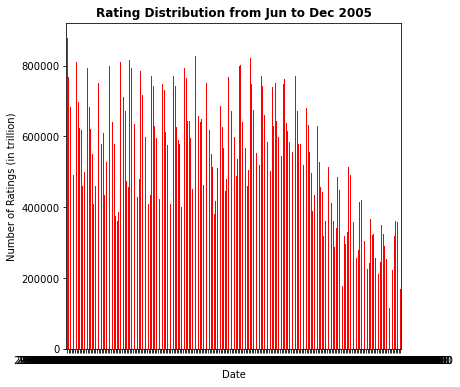

In [38]:
# set figure size 
plt.figure(figsize=(6,6))

# plot the ratings in a chart
d2.groupby("date")["rating"].sum().plot(kind='bar', color='r')

# set the respective labels 
plt.xticks(rotation=0)
plt.xlabel('Date')
plt.ylabel('Number of Ratings (in trillion)')
plt.title('Rating Distribution from Jun to Dec 2005', fontweight="bold")

<Figure size 1080x720 with 0 Axes>

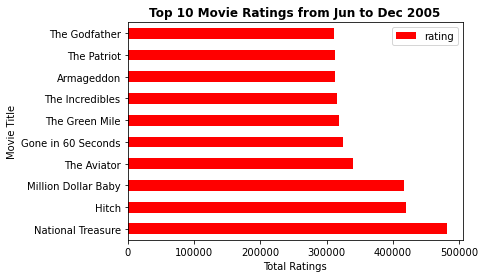

In [39]:
# sum of all ratings by movie title
mt_rank2 = d2.groupby("movie_title")["rating"].sum()

# sort them by highest rating first
mt_rank2 = mt_rank2.sort_values(ascending=False)

# convert to dataframe
top_10mt2 = pd.DataFrame(mt_rank2.head(10))
top_10mt2

# set figure size 
plt.figure(figsize=(15,10))

# plot graph
top_10mt2.plot(kind='barh', color='r')

# set the respective labels 
plt.xlabel('Total Ratings')
plt.ylabel('Movie Title')
plt.title('Top 10 Movie Ratings from Jun to Dec 2005', fontweight='bold')
plt.show()

After several reduction, The Godfather still remains one of the Top 10 movies.

In [40]:
# Reset the index such that movie title is included in the DataFrame
mt_rank3 = pd.DataFrame(mt_rank2.sort_values(ascending=False)).reset_index()

# select top 1000 movies
top_1kmt = pd.DataFrame(mt_rank3.head(1000))
top_1kmt

,movie_title,rating
0,National Treasure,480842
1,Hitch,419639
2,Million Dollar Baby,417167
3,The Aviator,340076
4,Gone in 60 Seconds,324653
...,...,...
995,The Witches of Eastwick,28307
996,The Killing Fields,28243
997,Honey,28231
998,CSI: Season 4,28217


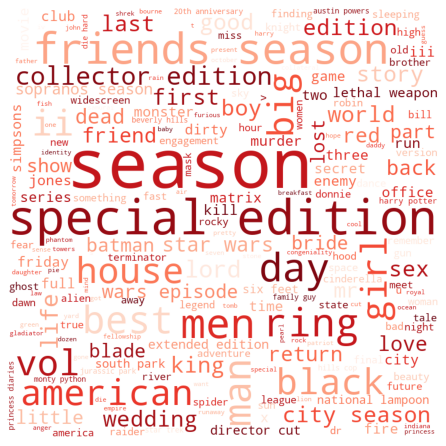

In [41]:
# Set up WordCloud 

comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the file 
for val in top_1kmt.movie_title: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split()  
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', 
                      stopwords = stopwords, colormap='Reds_r').generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [42]:
# export last 6 months of 2005 data to csv file
d2.to_csv('2005-d2.csv', index=False)  

#### (III) Decision 3 : To use 10 million of the data in Jun-Dec 2005 dataset. 

In [43]:
# to use 30 % of the data from the last 6 months of 2005. (approx 10 million rows of data)
df1, df2 = train_test_split(d2, test_size=0.30, random_state=42)

In [44]:
# check info of df2
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9475377 entries, 91463495 to 8562728
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   movie_id      int64         
 1   user_id       int64         
 2   rating        int64         
 3   date          datetime64[ns]
 4   release_year  int32         
 5   movie_title   object        
dtypes: datetime64[ns](1), int32(1), int64(3), object(1)
memory usage: 469.9+ MB


In [45]:
# export df2 data to csv file -- approx 10mil rows for the modeling
df2.to_csv('2005-d3.csv', index=False)  

#### (IV) Decision 4 : To use 5 million of the data in Jun-Dec 2005 dataset. 

In [46]:
# to use 54 % of the data from the 10 mil data over the last 6 months of 2005. (approx 5 million rows of data)
df3, df4 = train_test_split(df2, test_size=0.54, random_state=42)

In [47]:
# view of df4
df4.head()

,movie_id,user_id,rating,date,release_year,movie_title
33836115,6105,2606550,2,2005-08-21,2000,Paranoid
9477697,1865,482356,4,2005-11-09,2004,Eternal Sunshine of the Spotless Mind
26990921,4996,49106,4,2005-06-18,2000,Gone in 60 Seconds
6660362,1307,1090820,3,2005-07-17,2003,S.W.A.T.
53007510,9628,502622,3,2005-09-02,1983,Star Wars: Episode VI: Return of the Jedi


In [48]:
# check the info of newly-created df4
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5116704 entries, 33836115 to 99286450
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   movie_id      int64         
 1   user_id       int64         
 2   rating        int64         
 3   date          datetime64[ns]
 4   release_year  int32         
 5   movie_title   object        
dtypes: datetime64[ns](1), int32(1), int64(3), object(1)
memory usage: 253.7+ MB


In [49]:
# count the number of unique movie ID 
print("Total number of Movies: ", df4['movie_id'].nunique())

# count the number of unique user ID 
print("Total number of Users: ", df4['user_id'].nunique())

Total number of Movies:  17512
Total number of Users:  347978


In [50]:
# preview rating date range
print(df4['date'].min(), "&", df4['date'].max())

2005-06-01 00:00:00 & 2005-12-31 00:00:00


In [51]:
# preview rating date range
print(df4['release_year'].min(), "&", df4['release_year'].max())

1896 & 2005


In [52]:
# export df4 data to csv file -- approx 5mil rows for the modeling
df4.to_csv('2005-d4.csv', index=False)  

<Figure size 1080x720 with 0 Axes>

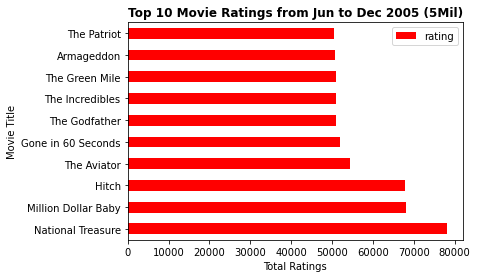

In [53]:
# sum of all ratings by movie title
mt_rank4 = df4.groupby("movie_title")["rating"].sum()

# sort them by highest rating first
mt_rank4 = mt_rank4.sort_values(ascending=False)

# convert to dataframe
top_10mt4 = pd.DataFrame(mt_rank4.head(10))
top_10mt4

# set figure size 
plt.figure(figsize=(15,10))

# plot graph
top_10mt4.plot(kind='barh', color='r')

# set the respective labels 
plt.xlabel('Total Ratings')
plt.ylabel('Movie Title')
plt.title('Top 10 Movie Ratings from Jun to Dec 2005 (5Mil)', fontweight='bold')
plt.show()

In [54]:
# check the number of unique movies in df4
df4.movie_id.nunique()

17512

In [55]:
# Select count function 
f = ['count']

# Group the 5mil data by the number of ratings per movie_id 
movie_summary = df4.groupby('movie_id')['rating'].agg(f)
movie_summary

,count
movie_id,
1,33
2,6
3,56
4,2
5,84
...,...
17766,29
17767,21
17768,53


In [56]:
# merge the two files, for a better overview
consol_movie = pd.merge(movie_summary, movie_df, on='movie_id', how='outer')
consol_movie

,movie_id,count,release_year,movie_title
0,1,33.0,2003,Dinosaur Planet
1,2,6.0,2004,Isle of Man TT 2004 Review
2,3,56.0,1997,Character
3,4,2.0,1994,Paula Abdul's Get Up & Dance
4,5,84.0,2004,The Rise and Fall of ECW
...,...,...,...,...
17765,17477,NaN,1991,Giuseppe Verdi: Attila: Teatro Alla Scala
17766,17542,NaN,1999,The True Story of Private Ryan
17767,17553,NaN,1998,Swing Craze
17768,17663,NaN,2002,3-2-1 Penguins: Trouble on Planet Wait-Your-Turn


In [57]:
# Sort them with the highest ranking and collect the top 1000 movie ratings 

top1k_mt = consol_movie.sort_values('count', ascending=False).head(1000).reset_index()
top1k_mt

,index,movie_id,count,release_year,movie_title
0,16919,17169,20658.0,2004,National Treasure
1,17073,17324,17521.0,2005,Hitch
2,11629,11812,16426.0,2004,Million Dollar Baby
3,12768,12966,15496.0,2004,The Aviator
4,5229,5317,14850.0,2000,Miss Congeniality
...,...,...,...,...,...
995,1679,1709,1242.0,1981,Clash of the Titans
996,14842,15064,1240.0,1988,Dangerous Liaisons
997,8158,8295,1238.0,2003,Holes
998,8273,8413,1235.0,2003,Girl with a Pearl Earring


In [58]:
# Export the file to csv for further recommendations in the next two files. 
top1k_mt.to_csv('2005-d41kMT.csv') 

# -- End of Capstone Files (1/3) --